In [101]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import shap
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# 读取并处理数据
df = pd.read_csv("C:/Users/Lenovo/Desktop/new_study/CNS/output/ASP_filtering.csv")
X = df.drop(columns=["LABEL","SEQUENCE","MIC"]).values
y = df["LABEL"].values
# 获取特征名
feature_names = df.drop(columns=["LABEL", "SEQUENCE", "MIC"]).columns.tolist()

In [103]:
print(X)
print(feature_names)

[[  0.      9.091   0.    ...  63.636  72.727 100.   ]
 [  0.     50.      0.    ...  45.     65.    100.   ]
 [  8.696   0.      4.348 ...  43.478  52.174  91.304]
 ...
 [  8.824   2.941   8.824 ...  17.647  38.235  67.647]
 [  3.333   6.667  10.    ...  46.667  76.667 100.   ]
 [ 16.667   5.556   0.    ...   2.778  72.222  83.333]]
['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'I', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'AA', 'AR', 'AN', 'AD', 'AE', 'AQ', 'AG', 'AI', 'AL', 'AF', 'AP', 'AS', 'AT', 'AY', 'AV', 'RR', 'RD', 'RE', 'RL', 'RK', 'RF', 'RP', 'RT', 'RW', 'RY', 'NA', 'NR', 'ND', 'NE', 'NG', 'NI', 'NL', 'NK', 'NP', 'NS', 'NT', 'NV', 'DA', 'DR', 'DN', 'DD', 'DE', 'DQ', 'DG', 'DH', 'DI', 'DL', 'DK', 'DF', 'DP', 'DS', 'DT', 'DV', 'CG', 'CL', 'CF', 'CP', 'CS', 'EA', 'ER', 'EN', 'ED', 'EE', 'EQ', 'EG', 'EH', 'EI', 'EL', 'EK', 'EM', 'EF', 'EP', 'ES', 'ET', 'EV', 'QA', 'QN', 'QD', 'QE', 'QQ', 'QH', 'QI', 'QL', 'QF', 'QP', 'QS', 'QT', 'QW', 'QV', 'GA', 'GR', 'GN', 'GD', 'GC', 'GE', 'GQ', 'G

In [104]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# 处理不平衡数据
sm =  BorderlineSMOTE(random_state= 42 ,kind="borderline-1")
X_resampled_train, y_resampled_train = sm.fit_resample(X_train, y_train)

In [105]:
#print(X_train)
print(X_resampled_train)

[[ 15.385        0.           0.         ...  46.154       46.154
   46.154     ]
 [ 23.077        0.           0.         ...  46.154       46.154
  100.        ]
 [  0.           0.           0.         ...  22.222       22.222
   66.667     ]
 ...
 [  7.03365669   7.6239575    3.51682834 ...  30.79168083  59.51752281
   92.05621515]
 [  5.86287084  19.07305435   2.64168796 ...  54.95950516  72.42138684
   91.49485996]
 [ 10.77899857   7.66277056   8.224614   ...  35.88738457  54.32977056
   90.77899857]]


In [106]:
# 创建深度学习模型
model = nn.Sequential(
    nn.Linear(X_resampled_train.shape[1], 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

In [107]:
# 训练模型
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_resampled_train_torch = torch.from_numpy(X_resampled_train.astype(np.float32))
y_resampled_train_torch = torch.from_numpy(y_resampled_train.astype(np.float32))

for epoch in range(3000):
    y_pred = model(X_resampled_train_torch).squeeze()
    loss = criterion(y_pred, y_resampled_train_torch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [108]:
# 确定模型的预测
y_pred_test = model(X_test_torch).detach().numpy().squeeze()
y_pred_train = model(X_resampled_train_torch).detach().numpy().squeeze()

# 回归任务的评估指标计算
#r2 = r2_score(y_test, y_pred_test)
#mse = mean_squared_error(y_test, y_pred_test)
#mae = mean_absolute_error(y_test, y_pred_test)
#print(f'R^2: {r2}')
#print(f'MSE: {mse}')
#print(f'MAE: {mae}')

# 分类任务的评估指标计算
# 需要将预测值转换成类别标签
y_pred_test_class = np.where(y_pred_test > 0.5, 1, 0)
y_pred_train_class = np.where(y_pred_train > 0.5, 1, 0)
# 模型预测概率 (这个用的是模型输出前需要sigmoid的结果，即得到概率）
y_pred_test_class = np.where(y_pred_test > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred_test_class)
recall = recall_score(y_test, y_pred_test_class)
precision = precision_score(y_test, y_pred_test_class)
# 计算AUC值
auc_test = roc_auc_score(y_test, y_pred_prob_test)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'Test AUC: {auc_test}')

Accuracy: 0.9583333333333334
Recall: 0.9210526315789473
Precision: 0.8333333333333334
Test AUC: 0.9917926003126628


In [109]:
# 利用训练好的模型和 SHAP 对特征重要性进行解释
background = torch.from_numpy(X_resampled_train.astype(np.float32))
explainer = shap.DeepExplainer(model, background)
X_test_torch = torch.from_numpy(X_test.astype(np.float32))
shap_values = explainer.shap_values(X_test_torch)

In [110]:
# 计算每个特征的平均绝对SHAP值
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# 创建 DataFrame 方便后续操作
important_df = pd.DataFrame(data=feature_names, columns=['Feature'])
important_df['Importance'] = mean_shap_values
# 按照Importance列排序，大的值在上面
important_df = important_df.sort_values(by='Importance', ascending=False).head(40)
print(important_df)

                        Feature  Importance
341                _ChargeD3100    0.082025
263                          Mw    0.057650
339                _ChargeD3050    0.029164
315              _PolarityD2075    0.028233
372  _SolventAccessibilityD3100    0.024902
285        _HydrophobicityD3001    0.024093
8                             K    0.021206
10                            F    0.019984
296        _NormalizedVDWVD2025    0.019517
293        _NormalizedVDWVD1075    0.018387
358          _SecondaryStrD3100    0.018363
371  _SolventAccessibilityD3075    0.016184
332                _ChargeD1100    0.016052
389        _PolarizabilityD3025    0.015774
14                            W    0.014494
11                            P    0.013859
383        _PolarizabilityD2001    0.013581
264               charge of all    0.013216
338                _ChargeD3025    0.013167
384        _PolarizabilityD2025    0.012972
379        _PolarizabilityD1025    0.012035
319              _PolarityD3050 

In [111]:
# 保存结果到 CSV 文件
important_df.to_csv("C:/Users/Lenovo/Desktop/new_study/CNS/output/Neural_Network_importance.csv", index=False)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



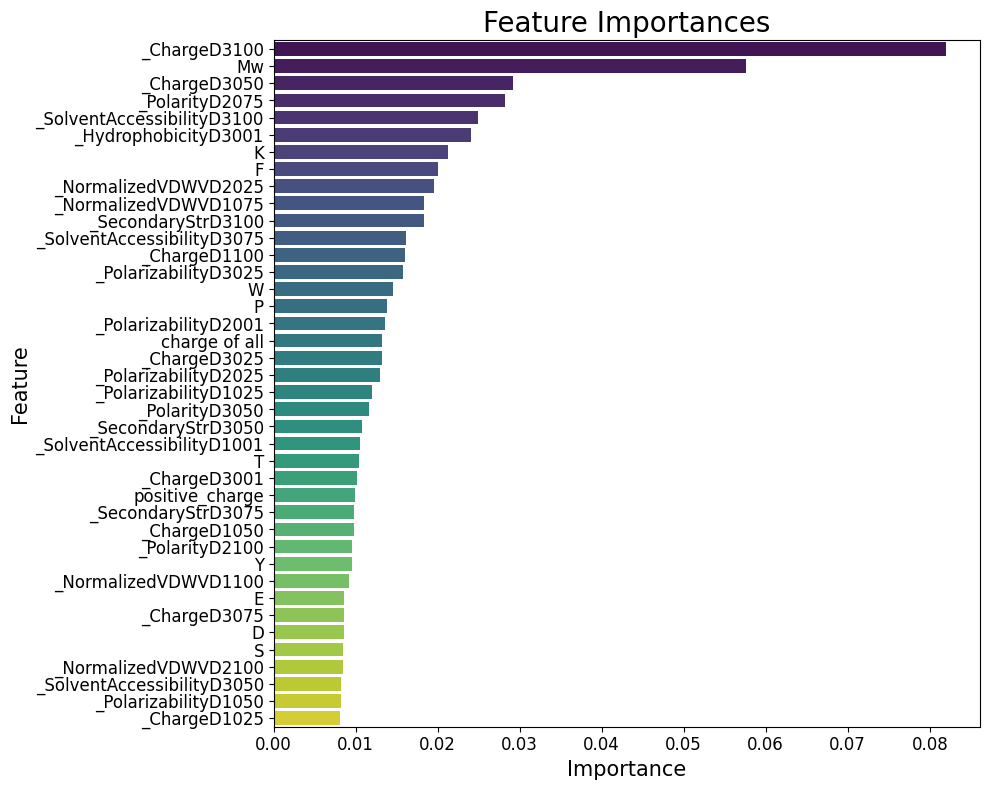

In [112]:
# 设置图形大小
plt.figure(figsize=(10, 8))

# 使用seaborn的barplot函数创建一个横向的柱状图，加入颜色映射
sns.barplot(x='Importance', y='Feature', data=important_df, palette='viridis')

plt.title('Feature Importances', fontsize=20)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 自动调整布局
plt.tight_layout()

plt.savefig(r'C:\Users\Lenovo\Desktop\new_study\CNS\output\Neural_Network_figure.png')
# 显示图形
plt.show()

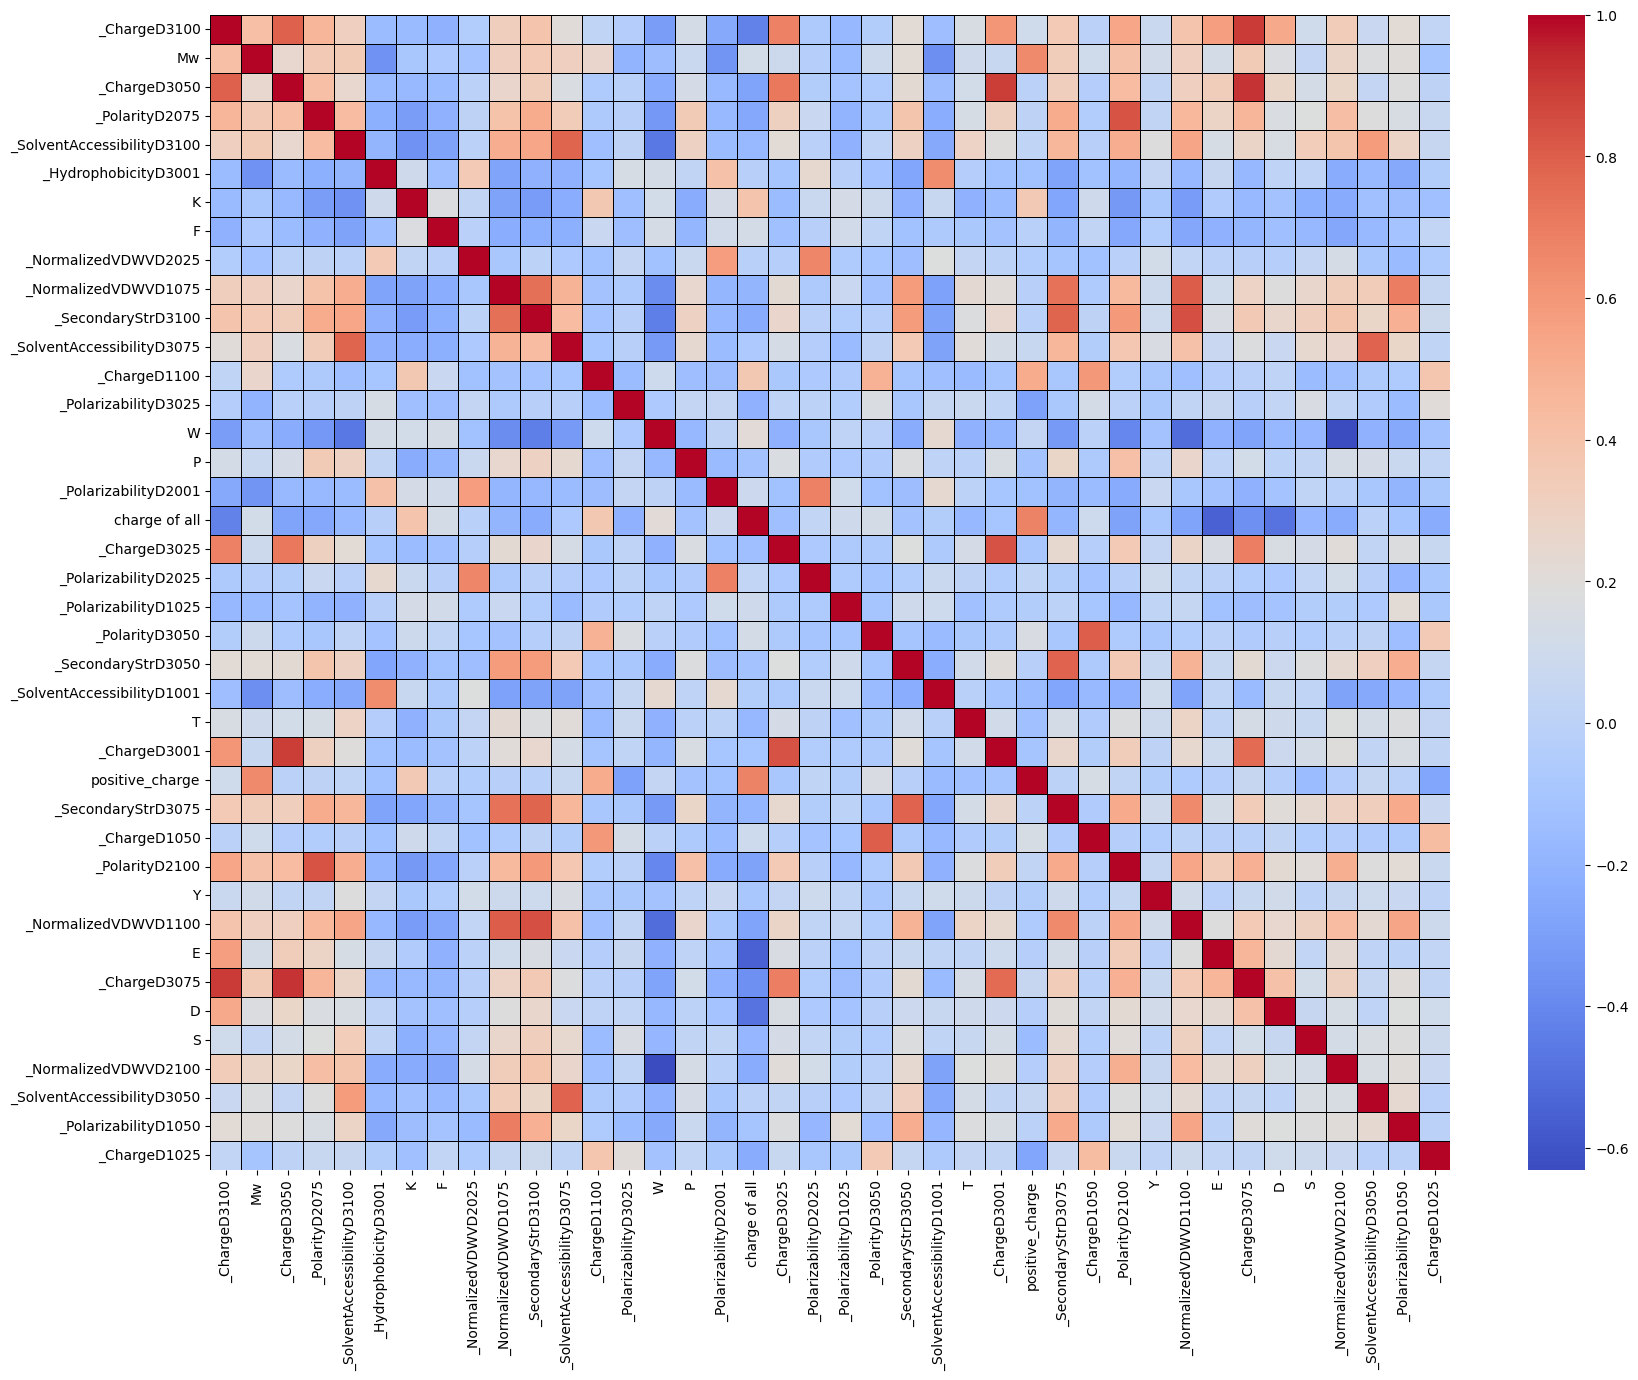

In [113]:
import seaborn as sns
import pandas as pd
import numpy as np

feature_selected_df = df[important_df["Feature"]]

# 计算特征之间的相关性
corr = feature_selected_df.corr()

# 创建一个新的图形，你可以根据需要调整图形的大小
plt.figure(figsize=(20, 15))

# 绘制热力图
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm',
            linewidths=0.5, # 添加边框
            linecolor='black') # 边框颜色

plt.savefig("C:/Users/Lenovo/Desktop/new_study/CNS/output/Neural_Network_heatmap.png")
# 显示图形
plt.show()